In [1]:
import os

import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
import numpy.linalg      as la

from matplotlib.pyplot   import imshow, subplot, title, plot

from ipywidgets          import interactive

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)
        
        
### HERRAMIENTAS

# crea un vector (array 1D)
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]


# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas 
def htrans(h,x):
    return inhomog(homog(x) @ h.T)

def desp(d):
    dx,dy = d
    return np.array([
            [1,0,dx],
            [0,1,dy],
            [0,0,1]])

def scale(s):
    sx,sy = s
    return np.array([
            [sx,0,0],
            [0,sy,0],
            [0,0,1]])

# rotación eje "vertical" del plano
def rot3(a):
    c = np.cos(a)
    s = np.sin(a)
    return np.array([
            [c,-s,0],
            [s, c,0],
            [0, 0,1]])

pi = np.pi
degree = pi/180

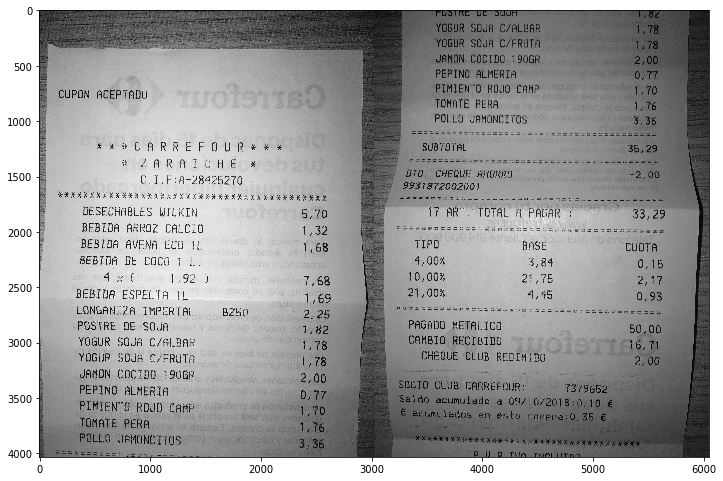

In [2]:
rgb1 = readrgb('../tickets_imagenes/181010_carreforur_conflash_1.JPG')
rgb2 = readrgb('../tickets_imagenes/181010_carreforur_conflash_2.JPG')
#rgb3 = readrgb('../tickets_imagenes/181010_carreforur_conflash_3.JPG')

x1 = rgb2gray(rgb1)
x2 = rgb2gray(rgb2)
#x3 = rgb2gray(rgb3)

fig(12,12)
#imshowg(np.hstack([x1,x2,x3]));
imshowg(np.hstack([x1,x2]));

# kps1: 500, descriptors1: (500, 32)


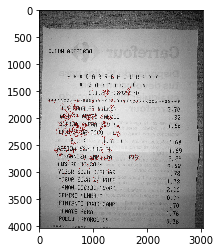

In [5]:
# Creamos un objeto SIFT. @see https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
orb = cv.ORB_create()
# "Detectamos y computamos" los puntos clave de la imagen. https://docs.opencv.org/3.1.0/d1/de0/tutorial_py_feature_homography.html
# TODO: Probar con SURF y modificar threshold para ver si se puede mejorar la eficiencia.
(kps1, descs1) = orb.detectAndCompute(x1, None)
print("# kps1: {}, descriptors1: {}".format(len(kps1), descs1.shape))

imshow( cv.drawKeypoints(image=x1,
                         keypoints=kps1,
                         outImage=None,
                         flags=4, color = (128,0,0)) );

# kps2: 500, descriptors2: (500, 32)


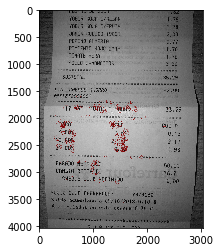

In [7]:
# Repetimos la operacion para la imagen 2
(kps2, descs2) = orb.detectAndCompute(x2, None)
print("# kps2: {}, descriptors2: {}".format(len(kps2), descs2.shape))

imshow( cv.drawKeypoints(image=x2,
                         keypoints=kps2,
                         outImage=None,
                         flags=4, color = (128,0,0)) );

In [8]:
# Creamos el objeto BFMatcher para encajar los descriptores hallados en el paso anterior
# ver https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
bf = cv.BFMatcher()
# Dibujamos los matches entre las imágenes 1 y 2
matches12 = bf.knnMatch(descs1,descs2,k=2)
# Dibujamos los matches entre las imágenes 2 y 3
#matches23 = bf.knnMatch(descs2,descs3,k=2)

len(matches12)
#len(matches23)

500

13


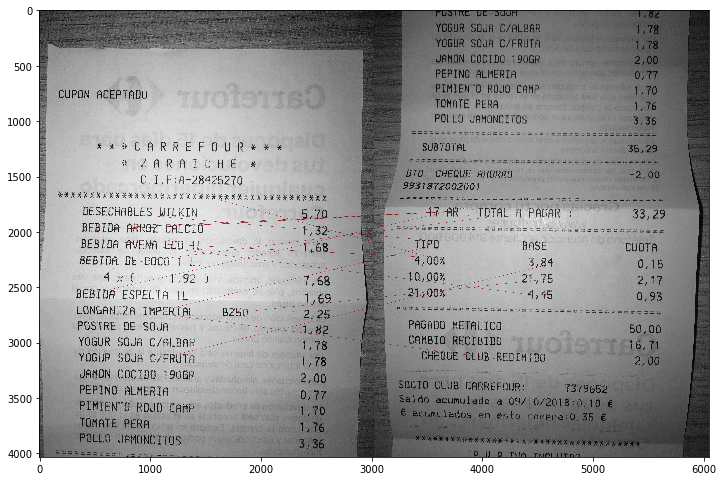

In [9]:
# para quedarnos solo los que tienen muy poca ambigüedad.

# Apply ratio test (1 & 2)
good12 = []
for m12,n12 in matches12:
    if m12.distance < 0.75*n12.distance:
        good12.append(m12)

print(len(good12))
  
# drawMatches usa la estructura matches1to2
img12 = cv.drawMatches(x1,kps1,
                      x2,kps2,
                      good12,
                      flags=2,outImg=None,
                      matchColor=(128,0,0))

fig(12,12)
plt.imshow(img12);


In [190]:
# a partir de los matchings seleccionados construimos los arrays de puntos que necesita findHomography
# ¡CUIDADO! Aquí 'm' sigue valiendo lo que valiera al salir del bucle anterior.
src_pts1 = np.array([ kps1[m12.trainIdx].pt for m12 in good12 ]).astype(np.float32).reshape(-1,2)
dst_pts2 = np.array([ kps2[m12.queryIdx].pt for m12 in good12 ]).astype(np.float32).reshape(-1,2)

#PRUEBA
#np.array([ kps1[m.trainIdx].pt for m1 in good12 ]).astype(np.float32).reshape(-1,2)
#FIN_PRUEBA

#src_pts2 = np.array([ kps2[m2.trainIdx].pt for m2 in good23 ]).astype(np.float32).reshape(-1,2)
#dst_pts3 = np.array([ kps3[m2.queryIdx].pt for m2 in good23 ]).astype(np.float32).reshape(-1,2)

IndexError: list index out of range

In [131]:
H, mask = cv.findHomography(src_pts1, dst_pts2, cv.RANSAC, 3) # cv.LMEDS
sharr(H)

None


In [32]:
# mask viene como una array 2D de 0 ó 1, lo convertimos a un array 1D de bool
matchesMask = mask.ravel()>0

ok = [ good[k] for k in range(len(good)) if matchesMask[k] ]

# good es una lista, si fuera un array prodríamos hacer directamente
# ok = good[matchesMask]

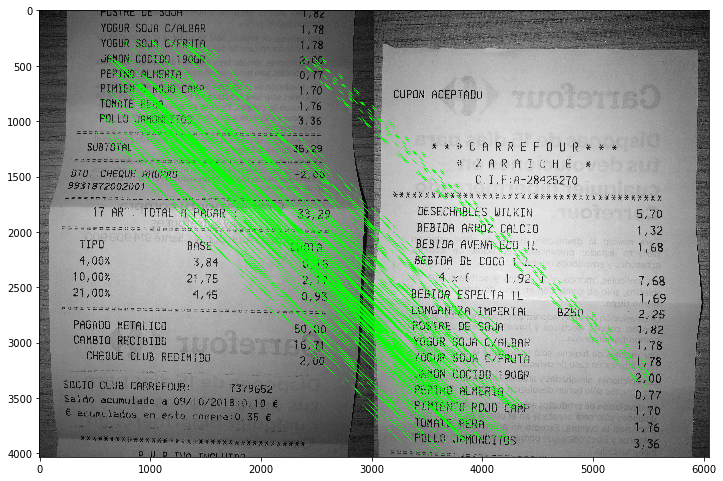

In [33]:
img4 = cv.drawMatches(x2,kps2,x1,kps,ok,flags=2,outImg=None,matchColor=(0,255,0))

fig(12,12)
plt.imshow(img4);

In [84]:
def t(h,x):
    return cv.warpPerspective(x, desp((200,2500)) @ h,(3500,10000))

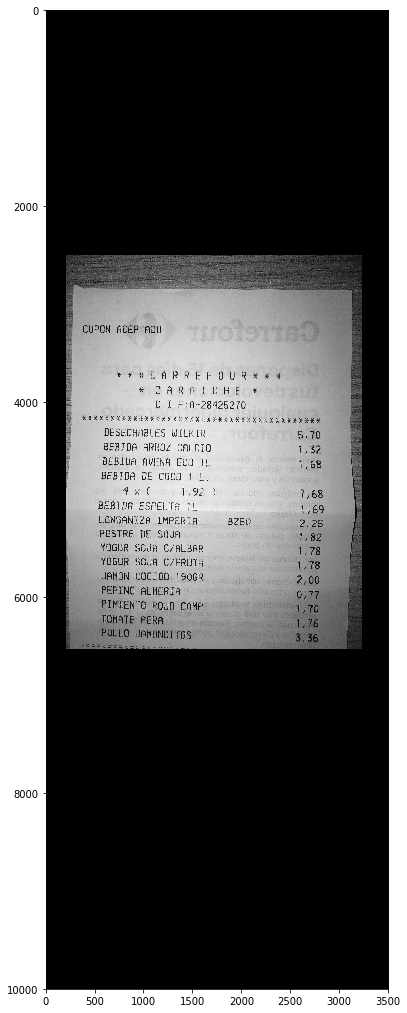

In [85]:
fig(18,18)

imshowg(t(np.eye(3),x1))

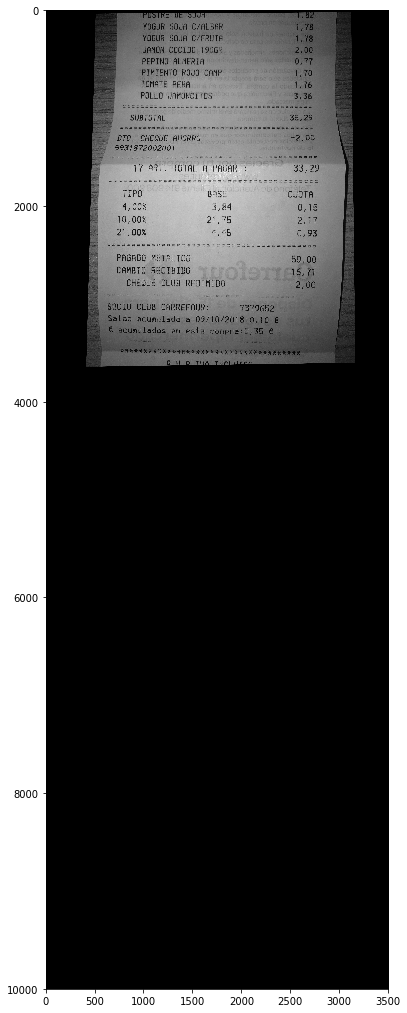

In [86]:
fig(18,18)

imshowg(t(H,x2))

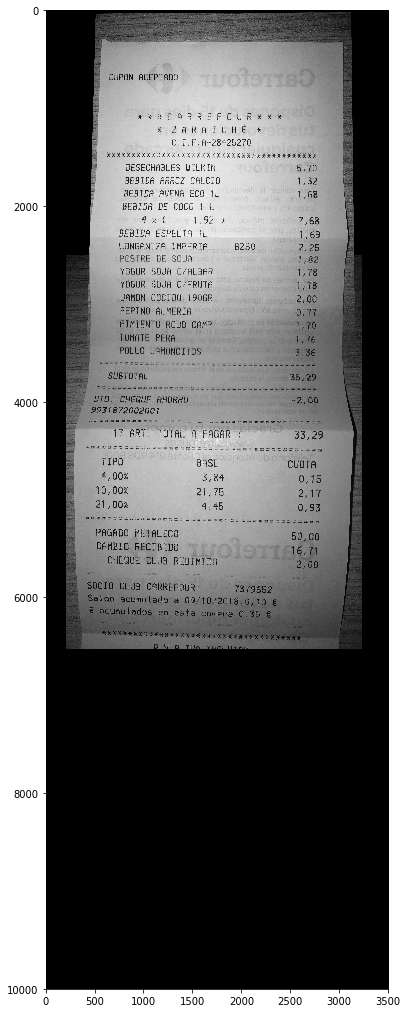

In [87]:
fig(18,18)

imshowg(np.maximum(t(np.eye(3),x2), t(H,x1)));